# <center> Budgeting App: An Exploratory Analysis

We used to write down all the transactions we made using a notebook or spreadsheet to understand how we spent our money. These approaches can be pretty time-consuming and require much effort. Budgeting apps help achieve financial goals by automating the tediousness of tracking personal budgets. 

This notebook conducts an exploratory analysis to inform the business strategy of a financial firm that operates a budgeting app. The firm has a mission of making budgeting accessible and stress-free. The app helps achieve financial goals by automating the tediousness of tracking personal budgets.

I use a dataset of 634 recurrences (transactions) that come in two types: savings (N = 153) and monthly expenses (N = 481). The dataset contains:
- information about 170 customers
- amounts used for savings and expenses
- days of the month when the money gets returned to customers to pay for expenses due

My findings indicate that most recurrences are expenses (76%), while the remaining (24%) are savings. The typical capacity of recurrences is about 1,420. But savings recurrences typically involve much larger capacity compared to expense recurrences. The most frequent and largest expense recurrences revolve around the beginning and end of the month, typically involving rent and car expenses. The most frequent savings recurrence involved emergency funds (22%). Interestingly, customers with the highest expense recurrences (top 10) are not the ones who have the highest savings recurrences. I hope these findings help further understand the app's partners and provide opportunities to improve the business strategy.

In [ ]:
#import Python libraries
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json 
import numpy as np
from wordcloud import WordCloud

In [ ]:
#read in the dataset into dataframe and display randomly selected rows
data = pd.read_csv('data.csv') 
data.sample(3)

,id,partnerID,name,recurrence,capacity
482,555,574,BCU Loan,"{""timing"":3,""dayOfTheMonth"":19}","{""cents"":{""numberOfDimes"":0,""numberOfPennies"":..."
412,451,387,Honda,"{""timing"":3,""dayOfTheMonth"":20}","{""cents"":{""numberOfDimes"":0,""numberOfPennies"":..."
600,675,812,Target,"{""timing"":3,""dayOfTheMonth"":16}","{""cents"":{""numberOfDimes"":0,""numberOfPennies"":..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          634 non-null    int64 
 1   partnerID   634 non-null    int64 
 2   name        634 non-null    object
 3   recurrence  634 non-null    object
 4   capacity    634 non-null    object
dtypes: int64(2), object(3)
memory usage: 24.9+ KB


## 1. Investigation of Recurrences
To explore recurrences, I retrieved the type of recurrence from JSON strings in the recurrence column and saved it to a new type column. Using this new column, I created a pie plot to depict the frequency distribution of the recurrence types. The plot reveals that most recurrences are expenses (76%), the remaining (24%) are savings.

To obtain the day of the month, I split the dataframe by recurrence type into two dataframes: expenses and savings (since only expense recurrences have a value for the date). Then, for the expenses dataframe, I retrieved values for dayOfTheMonth into a new day column. I created a frequency table and a count plot using this new column. The table and plot reveal that the most significant number of expense recurrences occurs on the 1st day of the month (26%). The second most frequent day for expense recurrences is the 28th day of the month (9%), while the 15th day is the third most frequent day for expense recurrences. 

The fact that a typical payday occurs during the beginning, end, and middle of the month may explain this observation. Also, the due date for housing rent is generally at the start of the month. Later in the notebook, I show that the average capacity for expense recurrences is the highest on the first day of the month. Also, rent is the most frequent type of expense.

In [ ]:
#parse JSON strings, convert them into Python dictionaries, and retrieve recurrence types from the recurrence column and values from the capacity column
data['type'] = data.recurrence.apply(lambda x: json.loads(x)['timing'])
data['capacity'] = data.capacity.apply(lambda x: json.loads(x)['dollars'])

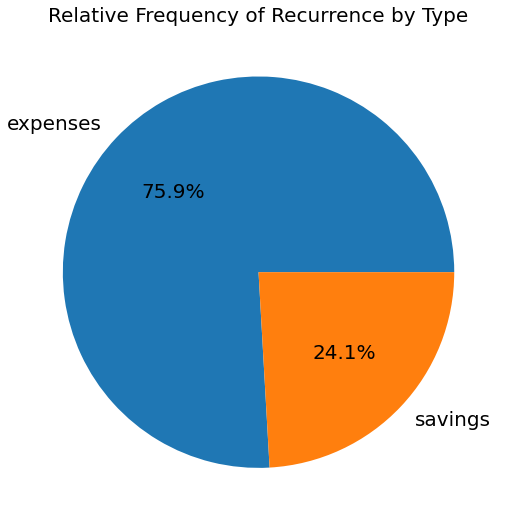

In [ ]:
#create pie plot for the type column 
round(data.type.value_counts(normalize=True)*100,1).plot.pie(labels=['expenses', 'savings'],
                                                             figsize=(9,9),autopct='%.1f%%', 
                                                             fontsize=20)
plt.title('Relative Frequency of Recurrence by Type',fontsize=20)
plt.ylabel('')
plt.show()

In [ ]:
#split dataframe into two: expenses and savings
expenses = data[data.recurrence.str.contains('"timing":3')].copy()
savings = data[data.recurrence.str.contains('"timing":0')].copy()

#retrieve values for dayOfTheMonth into the day column
expenses['day'] = expenses.recurrence.apply(lambda x: json.loads(x)['dayOfTheMonth']).copy() 

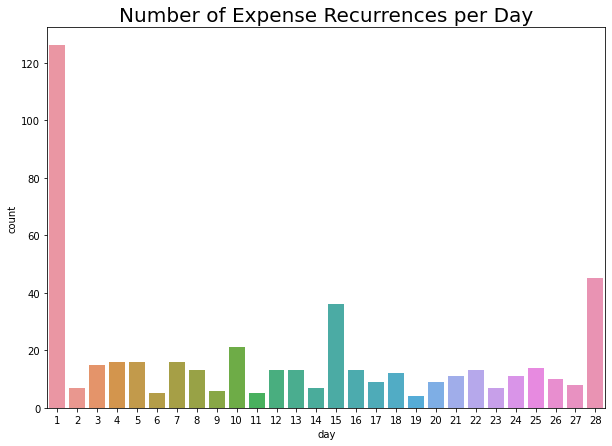

In [ ]:
#create count plot to show counts of expenses recurrences in each day
plt.figure(figsize=(10, 7))
sns.countplot(x='day', data=expenses)
plt.title('Number of Expense Recurrences per Day', fontsize=20)
plt.show()

In [ ]:
#create a frequency distribution table for the day column
round(expenses.day.value_counts(normalize=True)*100, 1)

1     26.2
28     9.4
15     7.5
10     4.4
4      3.3
7      3.3
5      3.3
3      3.1
25     2.9
8      2.7
16     2.7
13     2.7
22     2.7
12     2.7
18     2.5
24     2.3
21     2.3
26     2.1
17     1.9
20     1.9
27     1.7
23     1.5
2      1.5
14     1.5
9      1.2
11     1.0
6      1.0
19     0.8
Name: day, dtype: float64

## 2. Relationship between Recurrence and Capacity
I created a categorical plot to investigate the relationship between recurrence and capacity. The plot shows that, on average, values for savings recurrences (mean=347) are much higher than those for expense recurrences (mean=4,792). I also computed a pairwise correlation with a significant negative Pearson correlation coefficient (r=-0.60; savings and expenses were coded 0 and 3, respectively). These observations indicate that savings recurrences have a larger capacity than expense recurrences.

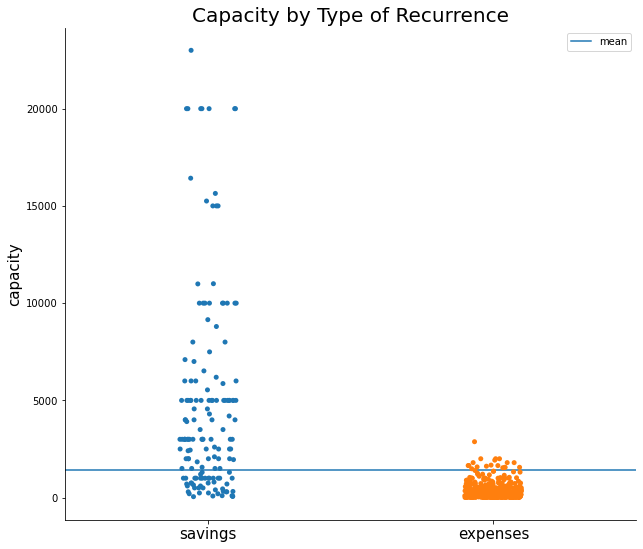

In [ ]:
#create cat plot for capacity and type columns
g = sns.catplot(x='type',y='capacity', data=data)
g.set_xticklabels(['savings', 'expenses'], fontsize=15)
g.set_axis_labels('', 'capacity', fontsize=15)
plt.title('Capacity by Type of Recurrence', fontsize=20)

plt.axhline(data.capacity.mean(), label='mean')
plt.legend()
plt.gcf().set_size_inches(10, 8)
plt.show()

In [ ]:
#compute a pairwise correlation between type and capacity columns
data[['type','capacity']].corr()

,type,capacity
type,1.000000,-0.597794
capacity,-0.597794,1.000000


## 3.  Exploration of Expense Purposes
To conduct an exploratory analysis using the name column, I converted all uppercase characters to lowercase and removed all emoji characters from text strings. 

I used a frequency table to demonstrate frequencies of recurrence purposes. The frequency table indicates that rent (15%), emergency fund (5%), car payment (5%), car (4%), and car insurance (3%) are the most frequent description of the purpose for the envelope. To depict this pattern visually, I generated a word cloud where the text font size is associated with the frequency of the purpose (the larger the font size, the higher the frequency).

To dig a little deeper, I identified all card expense recurrences and their relative frequency. Interestingly, only 4% of expense recurrences contain a "card" to describe the name of an envelope. I expected this percentage to be much higher. However, other names were used that may refer to credit card names (e.g., "discover," "capital one") that were not included in the total count because they did contain the "card" keyword. As such, further data cleaning is necessary for more accurate results.

In [ ]:
#convert all uppercase characters to lowercase
data.name = data.name.str.lower()
expenses.name = expenses.name.str.lower()
savings.name = savings.name.str.lower()

#use remove_emoji and regex to remove emoji characters
import re                          
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

data.name = data.name.apply(remove_emoji)
expenses.name = expenses.name.apply(remove_emoji)
savings.name = savings.name.apply(remove_emoji)

#remove white space 
data.name = data.name.str.strip()
expenses.name = expenses.name.str.strip()
savings.name = savings.name.str.strip()

In [ ]:
#create a frequency table for the ten most frequent strings in the name column
round(data.name.value_counts(normalize=True)[:10]*100,0)

rent              15.0
emergency fund     5.0
car payment        5.0
car                4.0
car insurance      3.0
internet           2.0
phone              2.0
electric           2.0
student loans      2.0
credit card        1.0
Name: name, dtype: float64

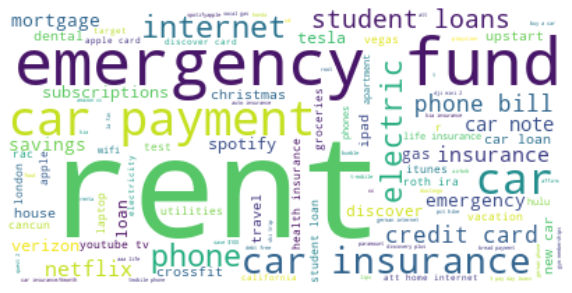

In [ ]:
# Generate a wordcloud
text = data.name.value_counts().to_dict()
wc = WordCloud(background_color="white",  max_font_size=100, max_words=100, 
               contour_width=1, contour_color='yellow').generate_from_frequencies(text)


# show
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#identify all card payments
expenses[expenses.name.str.contains('card')]

,id,partnerID,name,recurrence,capacity,type,day
52,85,144,discover card,"{""timing"":3,""dayOfTheMonth"":18}",100,3,18
53,86,144,capital card,"{""timing"":3,""dayOfTheMonth"":3}",100,3,3
69,102,259,credit card,"{""timing"":3,""dayOfTheMonth"":16}",100,3,16
70,103,259,credit card,"{""timing"":3,""dayOfTheMonth"":23}",100,3,23
99,134,314,discover card,"{""timing"":3,""dayOfTheMonth"":28}",300,3,28
100,135,314,apple card,"{""timing"":3,""dayOfTheMonth"":28}",200,3,28
133,168,350,credit card,"{""timing"":3,""dayOfTheMonth"":11}",500,3,11
240,278,489,citizens credit card,"{""timing"":3,""dayOfTheMonth"":12}",75,3,12
242,280,489,amex card,"{""timing"":3,""dayOfTheMonth"":12}",100,3,12
373,412,158,credit card,"{""timing"":3,""dayOfTheMonth"":13}",300,3,13


In [ ]:
#calculate an average capacity
card_percentage = round((len(expenses[expenses.name.str.contains('card')]) / len(expenses))*100, 0)
print("Percentage of card payments: {:.0f}".format(card_percentage))

Percentage of card payments: 4


## 4. Exploration of Capacity
The dataset has an average capacity of 1,420. Yet, savings capacity (mean=4,793 is substantially higher than expense capacity (mean=347).

The box plot shows that the capacity column has many outlying values with exceptionally high values, ranging from 10 to 23,000. The histogram indicates that the distribution of capacity values has a long right tail; this observation also occurs when histograms are created separately for expenses and savings recurrences. 

It is interesting to note that the highest expense recurrences tend to occur on the 1st and 28th of the month, as shown by the strip plot. As discussed earlier, the frequency of recurrences is also the highest on those days.

I also explored expense and savings recurrences per customer. Interestingly, the frequency tables show that customers with the highest expense recurrences (top 10) are not the ones who have the highest savings recurrences.

In [ ]:
# generate descriptive statistics for capacity column
data.describe()['capacity']

count      634.000000
mean      1419.911672
std       3184.468184
min         10.000000
25%         95.000000
50%        300.000000
75%       1000.000000
max      23000.000000
Name: capacity, dtype: float64

In [ ]:
print("Overall average capacity: {:.0f}".format(data.capacity.mean()))
print("Average expenses capacity: {:.0f}".format(expenses.capacity.mean()))
print("Average savings capacity: {:.0f}".format(savings.capacity.mean()))

Overall average capacity: 1420
Average expenses capacity: 347
Average savings capacity: 4793


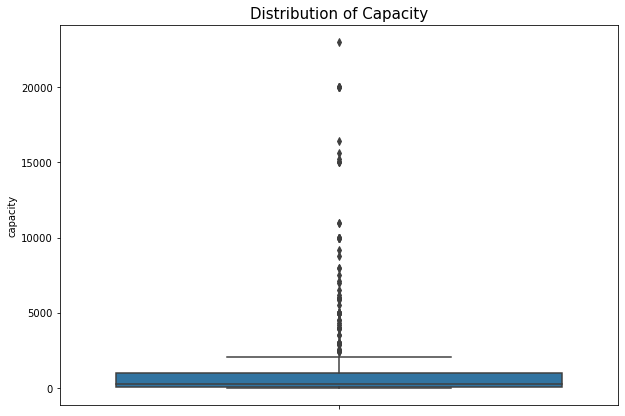

In [ ]:
#create box plot for capacity column
plt.figure(figsize=(10, 7))
sns.boxplot(data=data, y='capacity')
plt.title('Distribution of Capacity', fontsize=15)
plt.show()

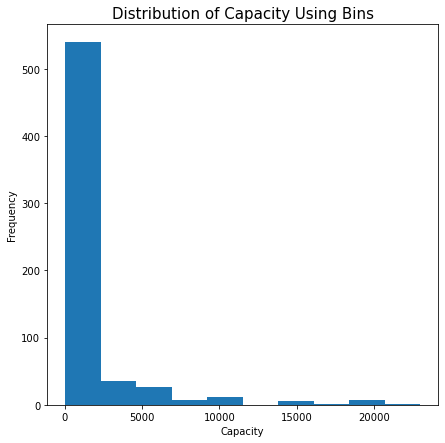

In [ ]:
#create histogram for capacity column
data.capacity.plot.hist(figsize=(7,7), bins=10)
plt.title('', fontsize=16)
plt.title('Distribution of Capacity Using Bins', fontsize=15)
plt.xlabel('Capacity')
plt.show()

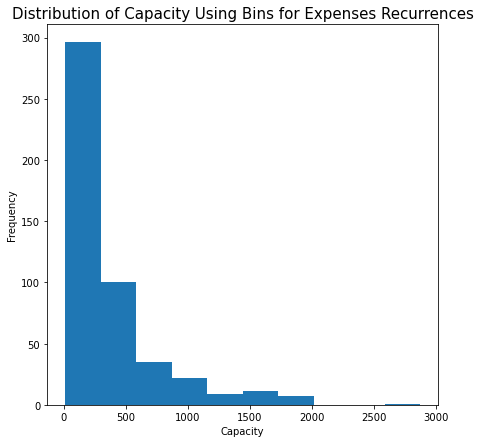

In [ ]:
#create histogram for capacity column for expense recurrences
expenses.capacity.plot.hist(figsize=(7,7), bins=10)
plt.title('', fontsize=16)
plt.title('Distribution of Capacity Using Bins for Expenses Recurrences', fontsize=15)
plt.xlabel('Capacity')
plt.show()

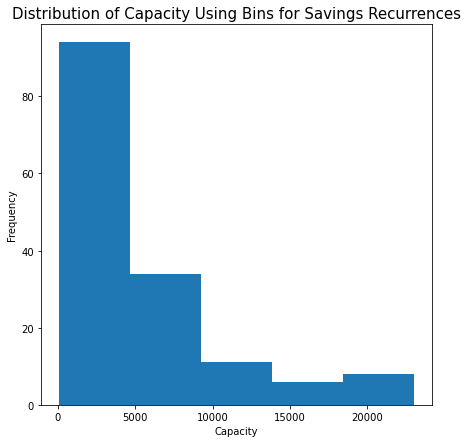

In [ ]:
#create histogram for capacity column for savings recurrences
savings.capacity.plot.hist(figsize=(7,7), bins=5)
plt.title('', fontsize=16)
plt.title('Distribution of Capacity Using Bins for Savings Recurrences', fontsize=15)
plt.xlabel('Capacity')
plt.show()

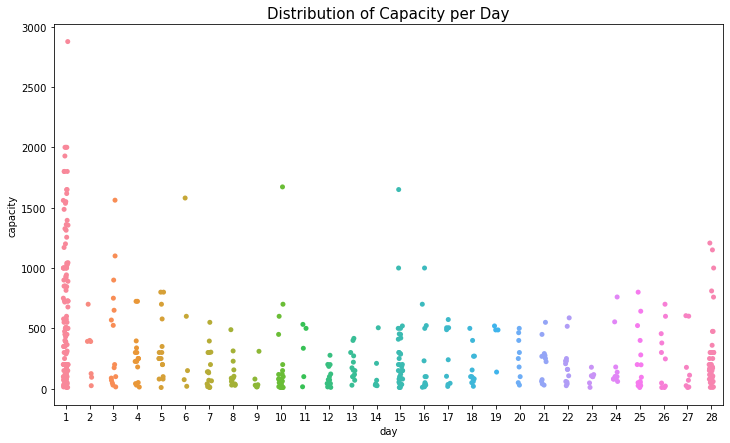

In [ ]:
#create strip plot for capacity per day
plt.figure(figsize=(12, 7))
sns.stripplot(x='day', y='capacity', data=expenses)
plt.title('Distribution of Capacity per Day', fontsize=15)
plt.show()

In [ ]:
#create frequency table of partners who have top 10 average expenses recurrences
partner_exp = expenses.groupby('partnerID')
partner_exp.capacity.mean().sort_values(ascending=False).head(10)

partnerID
410    2876.0
4      1650.0
275    1649.0
439    1617.0
206    1580.0
135    1536.0
46     1046.5
493    1040.0
271    1030.0
277    1000.0
Name: capacity, dtype: float64

In [ ]:
#create frequency table of partners who have top 10 average savings recurrences
partner_sav = savings.groupby('partnerID')
partner_sav.capacity.mean().sort_values(ascending=False).head(10)

partnerID
387    23000.0
477    20000.0
574    15642.0
723    15251.0
213    15000.0
852    10989.0
311    10000.0
33     10000.0
746     8799.0
249     8500.0
Name: capacity, dtype: float64

# Conclusion

I explored the behaviors of 170 customers. Most recurrences are expenses (76%), while the remaining (24%) are savings. The typical capacity of recurrences is about 1,420. But savings recurrences typically involve much larger capacity compared to expense recurrences. The most frequent and largest expense recurrences revolve around the beginning and end of the month, typically involving rent and car expenses. The most frequent savings recurrence involved emergency funds (22%). Interestingly, customers with the highest expense recurrences (top 10) are not the ones who have the highest savings recurrences. I hope these findings help further understand the app's partners and provide opportunities to improve the business strategy.